In [ ]:
!pip install medmnist

In [6]:
import medmnist
from medmnist import INFO, Evaluator

#import tensorflow as tf
#from tensorflow import keras
#from tensorflow.keras import layers

ImportError: cannot import name 'Evaluator' from 'medmnist' (c:\Users\DHutc\anaconda3\envs\tfenv\lib\site-packages\medmnist\__init__.py)

In [2]:
# see if GPU is available
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

NameError: name 'tf' is not defined

## Download the Data and set run parameters

In [5]:
data_flag = 'pathmnist'
# data_flag = 'breastmnist'
download = True

NUM_EPOCHS = 3
BATCH_SIZE = 128
lr = 0.01
n_classes = 9
info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

train_dataset = DataClass(split='train', download=download)
test_dataset = DataClass(split='test', download=download)

{'python_class': 'PathMNIST', 'description': 'The PathMNIST is based on a prior study for predicting survival from colorectal cancer histology slides, providing a dataset (NCT-CRC-HE-100K) of 100,000 non-overlapping image patches from hematoxylin & eosin stained histological images, and a test dataset (CRC-VAL-HE-7K) of 7,180 image patches from a different clinical center. The dataset is comprised of 9 types of tissues, resulting in a multi-class classification task. We resize the source images of 3×224×224 into 3×28×28, and split NCT-CRC-HE-100K into training and validation set with a ratio of 9:1. The CRC-VAL-HE-7K is treated as the test set.', 'url': 'https://zenodo.org/record/6496656/files/pathmnist.npz?download=1', 'MD5': 'a8b06965200029087d5bd730944a56c1', 'task': 'multi-class', 'label': {'0': 'adipose', '1': 'background', '2': 'debris', '3': 'lymphocytes', '4': 'mucus', '5': 'smooth muscle', '6': 'normal colon mucosa', '7': 'cancer-associated stroma', '8': 'colorectal adenocarci

AttributeError: module 'medmnist' has no attribute 'PathMNIST'

## Split the data into training, validation, and test data

In [ ]:
import numpy as np
npz_file = np.load('pathmnist.npz')

x_train = npz_file['train_images']
y_train = npz_file['train_labels']
x_val = npz_file['val_images']
y_val = npz_file['val_labels']
x_test = npz_file['test_images']
y_test = npz_file['test_labels']

## Info on the train and test dataset

In [ ]:
print("Train:")
print(train_dataset)
print()
print("Test:")
print(test_dataset)

Train:
Dataset PathMNIST (pathmnist)
    Number of datapoints: 89996
    Root location: C:\Users\DHutc\.medmnist
    Split: train
    Task: multi-class
    Number of channels: 3
    Meaning of labels: {'0': 'adipose', '1': 'background', '2': 'debris', '3': 'lymphocytes', '4': 'mucus', '5': 'smooth muscle', '6': 'normal colon mucosa', '7': 'cancer-associated stroma', '8': 'colorectal adenocarcinoma epithelium'}
    Number of samples: {'train': 89996, 'val': 10004, 'test': 7180}
    Description: The PathMNIST is based on a prior study for predicting survival from colorectal cancer histology slides, providing a dataset (NCT-CRC-HE-100K) of 100,000 non-overlapping image patches from hematoxylin & eosin stained histological images, and a test dataset (CRC-VAL-HE-7K) of 7,180 image patches from a different clinical center. The dataset is comprised of 9 types of tissues, resulting in a multi-class classification task. We resize the source images of 3×224×224 into 3×28×28, and split NCT-CRC-HE

In [ ]:
# print the unique labels in the dataset
y_train = keras.utils.to_categorical(train_dataset.labels)
#x_train = train_dataset.imgs
y_val = keras.utils.to_categorical(y_val)
y_test = keras.utils.to_categorical(test_dataset.labels)
#x_test = test_dataset.imgs

# normalize the input data
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
x_val = x_val.astype('float32') / 255.0
# resize the input data from 28x28 to 56x56 for resnet
x_train = tf.image.resize(x_train, (32, 32))
x_test = tf.image.resize(x_test, (32, 32))
x_val = tf.image.resize(x_val, (32, 32))

## Example of MedMNIST data

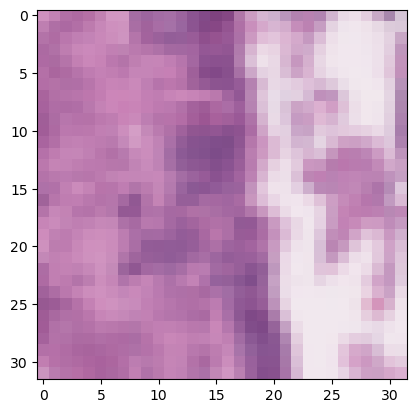

In [ ]:
from matplotlib import pyplot as plt
plt.imshow(x_train[20], interpolation='nearest')
plt.show()

In [ ]:
# 

#teacher = tf.keras.applications.resnet50.ResNet50(include_top=True, weights=None, input_shape=(32, 32, 3), classes= n_classes)
teacher = keras.models.Sequential([ 
    tf.keras.applications.resnet.ResNet50(include_top=False, weights='imagenet', pooling = 'avg', input_shape=(32, 32, 3)),
    tf.keras.layers.Dense(9, activation='softmax')
])
# Dont train the pre-trained resnet portiont as it detects features well, just train for the output layer
#teacher.layers[0].trainable = False
teacher.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy', 'category_accuracy'])
teacher.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense_3 (Dense)             (None, 9)                 18441     
                                                                 
Total params: 23,606,153
Trainable params: 18,441
Non-trainable params: 23,587,712
_________________________________________________________________


In [14]:
teacher.fit(x_train, y_train, epochs=10, validation_data=(x_val, y_val))
# Evaluate resnet on the test data
teacher.evaluate(x_test, y_test)

Epoch 1/10
2813/2813 [==============================] - 73s 23ms/step - loss: 2.0003 - accuracy: 0.2613 - val_loss: 1.8697 - val_accuracy: 0.3097
Epoch 2/10
2813/2813 [==============================] - 65s 23ms/step - loss: 1.8296 - accuracy: 0.3394 - val_loss: 1.7679 - val_accuracy: 0.3638
Epoch 3/10
2813/2813 [==============================] - 65s 23ms/step - loss: 1.7606 - accuracy: 0.3659 - val_loss: 1.7879 - val_accuracy: 0.3511
Epoch 4/10
2813/2813 [==============================] - 64s 23ms/step - loss: 1.7091 - accuracy: 0.3862 - val_loss: 1.7673 - val_accuracy: 0.4048
Epoch 5/10
2813/2813 [==============================] - 65s 23ms/step - loss: 1.6770 - accuracy: 0.3971 - val_loss: 1.6373 - val_accuracy: 0.4142
Epoch 6/10
2813/2813 [==============================] - 65s 23ms/step - loss: 1.6497 - accuracy: 0.4082 - val_loss: 1.6410 - val_accuracy: 0.4020
Epoch 7/10
2813/2813 [==============================] - 83s 30ms/step - loss: 1.6264 - accuracy: 0.4165 - val_loss: 1.6730 -

[1.3883198499679565, 0.5139275789260864]

In [15]:
# Knowledge Distillation!

class Distiller(keras.Model):
    def __init__(self, student, teacher):
        super().__init__()
        self.teacher = teacher
        self.student = student

    def compile(
        self,
        optimizer,
        metrics,
        student_loss_fn,
        distillation_loss_fn,
        alpha=0.1,
        temperature=3,
    ):
        """ Configure the distiller.

        Args:
            optimizer: Keras optimizer for the student weights
            metrics: Keras metrics for evaluation
            student_loss_fn: Loss function of difference between student
                predictions and ground-truth
            distillation_loss_fn: Loss function of difference between soft
                student predictions and soft teacher predictions
            alpha: weight to student_loss_fn and 1-alpha to distillation_loss_fn
            temperature: Temperature for softening probability distributions.
                Larger temperature gives softer distributions.
        """
        super().compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature

    def train_step(self, data):
        # Unpack data
        x, y = data

        # Forward pass of teacher
        teacher_predictions = self.teacher(x, training=False)

        with tf.GradientTape() as tape:
            # Forward pass of student
            student_predictions = self.student(x, training=True)

            # Compute losses with predetermined loss function
            student_loss = self.student_loss_fn(y, student_predictions)

            # Compute scaled distillation loss from https://arxiv.org/abs/1503.02531
            # The magnitudes of the gradients produced by the soft targets scale
            # as 1/T^2, multiply them by T^2 when using both hard and soft targets.
            # Distillation is performed with predetermined distillation function
            distillation_loss = (
                self.distillation_loss_fn(
                    tf.nn.softmax(teacher_predictions / self.temperature, axis=1),
                    tf.nn.softmax(student_predictions / self.temperature, axis=1),
                )
                * self.temperature**2
            )

            loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss

        # Compute gradients
        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Update the metrics configured in `compile()`.
        self.compiled_metrics.update_state(y, student_predictions)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update(
            {"student_loss": student_loss, "distillation_loss": distillation_loss}
        )
        return results

    def test_step(self, data):
        # Unpack the data
        x, y = data

        # Compute predictions
        y_prediction = self.student(x, training=False)

        # Calculate the loss
        student_loss = self.student_loss_fn(y, y_prediction)

        # Update the metrics.
        self.compiled_metrics.update_state(y, y_prediction)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update({"student_loss": student_loss})
        return results


In [16]:
teacher.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense_3 (Dense)             (None, 9)                 18441     
                                                                 
Total params: 23,606,153
Trainable params: 18,441
Non-trainable params: 23,587,712
_________________________________________________________________


In [17]:
student = keras.models.Sequential([
    layers.InputLayer(input_shape=(32, 32, 3)),
    layers.ZeroPadding2D(padding=3),
    layers.Conv2D(64, (23, 23), activation='relu', input_shape=(32, 32, 3)),
    layers.BatchNormalization(),
    layers.ZeroPadding2D(padding=1),
    layers.MaxPooling2D((11, 11), strides=(1, 1)),
    layers.Conv2D(64, (1, 1), activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(256, (1, 1), activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(64, (1, 1), activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(256, (1, 1), activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(64, (1, 1), activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(256, (1, 1), activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(64, (1, 1), activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(128, (1, 1), activation='relu'),
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])
student.summary()
# Clone student for later comparison
student_clone = keras.models.clone_model(student)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 zero_padding2d (ZeroPadding  (None, 38, 38, 3)        0         
 2D)                                                             
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 64)        101632    
                                                                 
 batch_normalization (BatchN  (None, 16, 16, 64)       256       
 ormalization)                                                   
                                                                 
 zero_padding2d_1 (ZeroPaddi  (None, 18, 18, 64)       0         
 ng2D)                                                           
                                                                 
 max_pooling2d (MaxPooling2D  (None, 8, 8, 64)         0         
 )                                                    

In [18]:
# Initialize and compile distiller
distiller = Distiller(student=student, teacher=teacher)
distiller.compile(
    optimizer=keras.optimizers.Adam(),
    metrics=[keras.metrics.CategoricalAccuracy(), 'accuracy'],
    student_loss_fn=keras.losses.CategoricalCrossentropy(from_logits=True),
    distillation_loss_fn=keras.losses.KLDivergence(),
    alpha=0.1,
    temperature=10,
)

# Distill teacher to student
student_history = distiller.fit(x_train, y_train, epochs=3, validation_data=(x_val, y_val))

# Evaluate student on test dataset
distiller.evaluate(x_test, y_test)

Epoch 1/3


c:\Users\DHutc\anaconda3\envs\tfenv\lib\site-packages\keras\backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


2813/2813 [==============================] - 100s 34ms/step - categorical_accuracy: 0.6245 - accuracy: 0.6245 - student_loss: 0.9928 - distillation_loss: 0.0128 - val_categorical_accuracy: 0.2204 - val_accuracy: 0.2204 - val_student_loss: 3.1221
Epoch 2/3
2813/2813 [==============================] - 96s 34ms/step - categorical_accuracy: 0.6929 - accuracy: 0.6929 - student_loss: 0.8306 - distillation_loss: 0.0150 - val_categorical_accuracy: 0.1880 - val_accuracy: 0.1880 - val_student_loss: 8.4621
Epoch 3/3
225/225 [==============================] - 2s 9ms/step - categorical_accuracy: 0.5372 - accuracy: 0.5372 - student_loss: 1.8888


[0.5371866226196289, 0.5371866226196289, 2.2018699645996094]

In [19]:
#Compile and train the student_clone for comparison. If the teacher is good, the student should outperform the student_clone.
student_clone.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
student_clone_history = student_clone.fit(x_train, y_train, epochs=3, validation_data=(x_val, y_val))
student_clone.evaluate(x_test, y_test)

Epoch 1/3
2813/2813 [==============================] - 43s 15ms/step - loss: 0.9901 - accuracy: 0.6230 - val_loss: 3.4340 - val_accuracy: 0.2522
Epoch 2/3
2813/2813 [==============================] - 41s 14ms/step - loss: 0.8306 - accuracy: 0.6889 - val_loss: 3.3876 - val_accuracy: 0.2640
Epoch 3/3
225/225 [==============================] - 2s 8ms/step - loss: 2.7224 - accuracy: 0.3638


[2.7223799228668213, 0.36378830671310425]

## Plot results

dict_keys(['categorical_accuracy', 'accuracy', 'student_loss', 'distillation_loss', 'val_categorical_accuracy', 'val_accuracy', 'val_student_loss'])


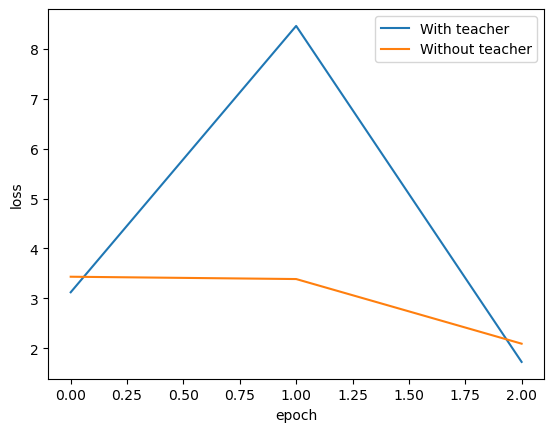

In [33]:
from matplotlib import pyplot as plt
print(student_history.history.keys())
plt.plot(student_history.history['val_student_loss'], label='With teacher')
plt.plot(student_clone_history.history['val_loss'], label='Without teacher')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()